## Grid refinement study for the flow around an obstacle

In [6]:
import lettuce as lt
import torch
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt

In [51]:
debug = True
nreport = 10
nconsole = 100
nmax = 10000
epsilon = 1e-5
Re = 10000
Ma = 0.01
lattice = lt.Lattice(lt.D2Q9, torch.device("cuda:0"), use_native=False)
length_x = 10.1
ny = 1000
nx = 2*ny

In [52]:
def mask_from_csv(x, y):
    nx1, ny1 = np.shape(x)
    n_wing_nose = int(nx1//4)    # wing starts after 1/4 of domain length
    n_wing_tail = int(nx1*3//4)  # wing goes until 3/4 of domain length
    n_wing_height = int(ny1//2)  # wing sits at middle of domain length

    # read wing data
    top_surface_data = np.fromfile('top_surface.csv', sep=' ', dtype=float)
    top_surface_data = np.reshape(top_surface_data, (int(len(top_surface_data)/2),2)).transpose()
    bottom_surface_data = np.fromfile('bottom_surface.csv', sep=' ', dtype=float)
    bottom_surface_data = np.reshape(bottom_surface_data, (int(len(bottom_surface_data)/2),2)).transpose()

    x_data_top = top_surface_data[0]
    y_data_top = top_surface_data[1]
    x_data_bottom = bottom_surface_data[0]
    y_data_bottom = bottom_surface_data[1]

    # calculate scaling factor
    x_wing_nose = x[n_wing_nose,0] # 2.525
    x_wing_tail = x[n_wing_tail,0] # 7.575
    available_length_x = x_wing_tail - x_wing_nose # 5.05
    available_length_n = n_wing_tail-n_wing_nose
    actual_wing_length_x = max(max(x_data_top), max(x_data_bottom)) # 100
    scaling_factor = available_length_x / actual_wing_length_x # 0.0505
    # scale wing data to fit domain restrictions
    x_data_top *= scaling_factor    # [5.05 ... 0]
    x_data_bottom *= scaling_factor # [0 ... 5.05]
    y_data_top *= scaling_factor    # [0 ... 0.39 ... 0]
    y_data_bottom *= scaling_factor # [0 ... -0.20 ... 0]

    # mapping data to the grid
    x_data_interp        = np.linspace(0, available_length_x, available_length_n)            # [0 ... 5.05]
    y_data_top_interp    = interpolate.interp1d(x_data_top, y_data_top)(x_data_interp)       # .interp1d object
    y_data_bottom_interp = interpolate.interp1d(x_data_bottom, y_data_bottom)(x_data_interp) # .interp1d object

    # shifting the wing up by half the grid
    y_wing_height = y[0, n_wing_height]
    y_data_top_interp += y_wing_height
    y_data_bottom_interp += y_wing_height

    # setting y data in a 2D grid to compare with flow.grid[1]
    y_data_top_mapped = np.zeros(np.shape(y))
    y_data_top_mapped[n_wing_nose:n_wing_tail, :] = np.array([y_data_top_interp]).transpose()
    y_data_bottom_mapped = np.zeros(np.shape(y))
    y_data_bottom_mapped[n_wing_nose:n_wing_tail, :] = np.array([y_data_bottom_interp]).transpose()

    # creating and plotting mask
    bool_mask = (y < y_data_top_mapped) & (y > y_data_bottom_mapped)
    if debug:
        plt.imshow(bool_mask.transpose(), origin="lower", cmap='gray_r')
        #plt.show()
    return bool_mask

In [53]:
def run(nx=200, ny=100, nmax=10000, Re=50.0, Ma=0.05, lattice=lt.Lattice(lt.D2Q9, device=torch.device("cuda:0"), use_native=False), length_x=10.1, *axes):
    flow = lt.Obstacle(
        (nx, ny),
        reynolds_number=Re,
        mach_number=Ma,
        lattice=lattice,
        domain_length_x=length_x
    )
    x, y = flow.grid
    flow.mask = mask_from_csv(x, y)
    axes[0].imshow(flow.mask.T, origin="lower")
    tau = flow.units.relaxation_parameter_lu
    simulation = lt.Simulation(flow, lattice, lt.BGKCollision(lattice, tau),
                        lt.StandardStreaming(lattice))

    # set up reporters
    Energy = lt.IncompressibleKineticEnergy(lattice, flow)
    energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
    simulation.reporters.append(energy_reporter_internal)
    simulation.reporters.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
    simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=nreport, filename_base="./data/out"))

    simulation.initialize_f_neq()
    energy_new = 0
    mlups = 0
    iterations = int(nmax//nconsole)
    for i in range(iterations):
        energy_old = energy_new
        energy_new = Energy(simulation.f).mean()
        mlups += simulation.step(nconsole)
        if abs((energy_new - energy_old)/energy_new) < epsilon or not energy_new == energy_new:
            print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
            print("avg MLUPS: ", mlups/i)
            u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f).detach().cpu().numpy())
            return axes[1].imshow(u[0,...].T, origin="lower")
    print("avg MLUPS: ", mlups/iterations)
    u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f).detach().cpu().numpy())
    return axes[1].imshow(u[0,...].T, origin="lower")

steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy
0 0.0 24.54168128967285
100 0.0029156188594076106 24.49919319152832
200 0.005831237718815221 24.47779655456543


KeyboardInterrupt: 

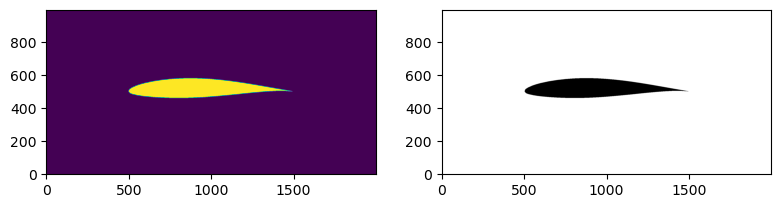

In [54]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
fig.subplots_adjust(right=0.85)
im2 = run(nx, ny, nmax, Re, Ma, lattice, length_x, *axes)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)